In [218]:
import pandas as pd
import re

origin_data = pd.read_csv(r'D:\python\datawhale\team-learning\trainning\house.csv')

In [ ]:
td = origin_data.loc[:,['mean_price', 'capacity']]
td = td.apply(lambda items: [re.match(r'^\d+', item).group(0) for item in items])
td.head()

In [45]:
x = td['capacity'].values.reshape(-1, 1)
y = td['mean_price'].values

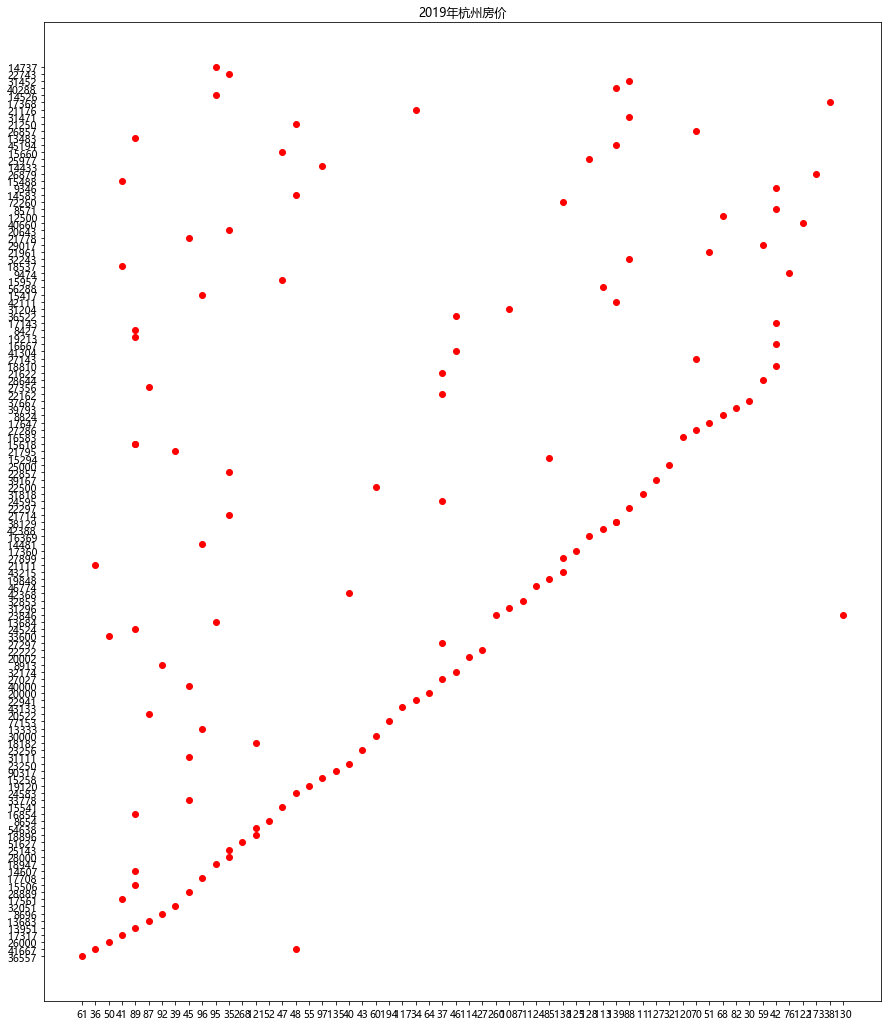

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 18))
ax = fig.add_subplot(111)
ax.set(title='2019年杭州房价')
ax.scatter(td['capacity'], td['mean_price'], c='r', marker='o')
plt.show()

In [38]:
x

array([['61', '36', '50', '41', '89', '87', '92', '39', '41', '45', '89',
        '96', '89', '95', '35', '35', '268', '121', '121', '52', '89',
        '47', '45', '48', '55', '97', '135', '40', '45', '43', '121',
        '60', '96', '194', '87', '117', '34', '64', '45', '37', '46',
        '92', '114', '27', '37', '50', '89', '95', '260', '108', '71',
        '40', '124', '85', '138', '36', '138', '125', '96', '128', '113',
        '139', '35', '88', '37', '11', '60', '127', '35', '32', '85',
        '39', '89', '120', '70', '51', '68', '82', '30', '37', '87',
        '59', '37', '42', '70', '46', '42', '89', '89', '89', '42', '46',
        '108', '139', '139', '96', '113', '47', '76', '41', '88', '51',
        '59', '48', '45', '35', '122', '68', '42', '138', '48', '42',
        '41', '173', '97', '128', '47', '139', '89', '70', '48', '88',
        '34', '38', '95', '139', '88', '35', '130', '95']], dtype=object)

In [46]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(x, y)
reg.score(x, y)
reg.coef_
reg.predict([[90]])

array([27280.2479657])

In [95]:
td = td.reset_index(drop=True)
td['mean_price'] = td.mean_price.astype('int')
td['expect'] = td['mean_price'] < 20000
len(td[td['expect'] == False])

1287

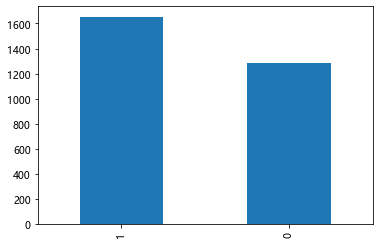

In [108]:
td['expect'] = td['expect'].astype('int')
td['expect'].value_counts().plot(kind='bar')

In [97]:
from sklearn.preprocessing import StandardScaler

td['normPrice'] = StandardScaler().fit_transform(td['mean_price'].values.reshape(-1,1))
td = td.drop('mean_price', axis=1)
td.head()

,capacity,expect,normPrice
0,80,0,0.233519
1,76,0,0.247246
2,75,0,1.567526
3,147,0,2.827893
4,50,1,-1.285230


In [102]:
features = td.drop('expect', axis=1)
labels = td.loc[:, 'expect']
labels == 1

0       False
1       False
2       False
3       False
4        True
        ...  
2935     True
2936     True
2937    False
2938    False
2939    False
Name: expect, Length: 2940, dtype: bool

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)

print("原始训练包含样本数量：", len(X_train))
print("原始测试包含样本数量：", len(X_test))
print("原始样本总数：", len(X_train) + len(X_test))

原始训练包含样本数量： 2058
原始测试包含样本数量： 882
原始样本总数： 2940


In [162]:
import numpy as np
# 错误的数量和index
fraud_indices = np.array(labels[labels==0].index)
number_records_fraud = len(fraud_indices)

# 正确样本的索引
normal_indices = np.array(labels[labels==1].index)
number_records_normal = len(normal_indices)

# 从错误的样本中取索引
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)

# 集成
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = td.iloc[under_sample_indices]
X_under_sample = under_sample_data.drop('expect', axis=1)
y_under_sample = under_sample_data['expect']

print('正常样本比例:', len(under_sample_data[under_sample_data['expect'] == 1])/ len(under_sample_data))
print('异常样本比例:', len(under_sample_data[under_sample_data['expect'] == 0])/ len(under_sample_data))
print('总量:', len(under_sample_data))

正常样本比例: 0.5
异常样本比例: 0.5
总量: 2574


In [153]:
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_under_sample, y_under_sample, test_size=0.3, random_state=0)

print('下采样训练集包含样本数量', len(X_train_undersample))
print('下采样测试集包含样本数量', len(X_test_undersample))
print('下采样本总数量', len(X_train_undersample) + len(X_test_undersample))

下采样训练集包含样本数量 1801
下采样测试集包含样本数量 773
下采样本总数量 2574


In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score,classification_report
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score

In [185]:
def Kfold_score(x_train, y_train):
    fold = KFold(5, shuffle=False)
    c_param_range = [0.01, 0.1, 1, 10, 100]
    result_table = pd.DataFrame(index=range(len(c_param_range)), columns=['C', 'recall score', 'accuracy score'])
    result_table['C'] = c_param_range

    for j, c in enumerate(c_param_range):
        print('-------')
        print('正则化惩罚力度', c)
        print('-------')
        accs = []
        acus = []
        for i, indices in enumerate(fold.split(y_train), start=1):
            train, test = indices
            lr = LogisticRegression(C=c)
            lr.fit(x_train.iloc[train], y_train.iloc[train].values.ravel())
            y_pred = lr.predict(x_train.iloc[test])
            recall = recall_score(y_train.iloc[test], y_pred)
            accuracy = accuracy_score(y_train.iloc[test], y_pred)
            accs.append(recall)
            acus.append(accuracy)
            print('召回率:', recall, '精准度: ', accuracy)
        result_table.loc[j, 'recall score'] = np.mean(accs)
        result_table.loc[j, 'accuracy score'] = np.mean(acus)
        print('==================')
        print('平均召回率:', np.mean(accs))
        print('平均精准度:', np.mean(acus))
        print('===================\n\n')
    print(result_table)
    print(result_table.loc[:,'recall score'].astype('float32').idxmax())
    best_c = result_table.iloc[result_table.loc[:,'recall score'].astype('float32').idxmax()]['C']
    print('*********************')
    print('最好结果是', best_c)
    return best_c

In [188]:
best_c = Kfold_score(X_train_undersample, y_train_undersample)

-------
正则化惩罚力度 0.01
-------
召回率: 0.949438202247191 精准度:  0.9335180055401662
召回率: 0.9710982658959537 精准度:  0.9222222222222223
召回率: 0.9516129032258065 精准度:  0.9222222222222223
召回率: 0.9764705882352941 精准度:  0.9222222222222223
召回率: 0.9947368421052631 精准度:  0.9111111111111111
平均召回率: 0.9686713603419017
平均精准度: 0.9222591566635889


-------
正则化惩罚力度 0.1
-------
召回率: 0.9719101123595506 精准度:  0.9806094182825484
召回率: 0.976878612716763 精准度:  0.9805555555555555
召回率: 0.9838709677419355 精准度:  0.9861111111111112
召回率: 1.0 精准度:  0.9888888888888889
召回率: 0.9947368421052631 精准度:  0.9833333333333333
平均召回率: 0.9854793069847025
平均精准度: 0.9838996614342875


-------
正则化惩罚力度 1
-------
召回率: 0.9719101123595506 精准度:  0.9861495844875346
召回率: 0.976878612716763 精准度:  0.9888888888888889
召回率: 0.9838709677419355 精准度:  0.9916666666666667
召回率: 1.0 精准度:  1.0
召回率: 1.0 精准度:  1.0
平均召回率: 0.9865319385636498
平均精准度: 0.993341028008618


-------
正则化惩罚力度 10
-------
召回率: 0.9831460674157303 精准度:  0.9916897506925207
召回率: 0.9884393063583815

In [280]:
import itertools
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """混淆矩阵"""
    shapes = cm.shape
    plt.imshow(cm, cmap=cmap, extent=[0, shapes[1], 0, shapes[0]])
    plt.title(title)
    plt.colorbar()
    tick_marks = range(shapes[0])
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(shapes[0]), range(shapes[1])):
        plt.text(j + 0.5, shapes[0] - 0.5 - i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[383   0]
 [  0 390]]
计算召回率:  inf
框架召回率: 1.0
C:\Users\sishi\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


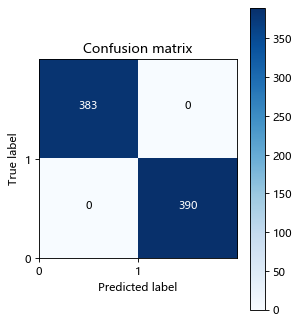

In [298]:
%matplotlib inline
lr = LogisticRegression(C=best_c)
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_undersample_test_pred = lr.predict(X_test_undersample)

cnf_matrix = confusion_matrix(y_test_undersample, y_undersample_test_pred)
np.set_printoptions(precision=2)

print(cnf_matrix)
print("计算召回率: ", cnf_matrix[1,1]/cnf_matrix[1,0]+cnf_matrix[1,1])
print('框架召回率:', recall_score(y_test_undersample, y_undersample_test_pred))

plt.figure(figsize=(4,5), dpi=80)
plot_confusion_matrix(cnf_matrix, title="Confusion matrix")
plt.show()

In [299]:
start = 10
end = 15
prices = [int(re.match(r'^\d+', price).group(0)) for price in origin_data['mean_price']]
capacity = [int(re.match(r'^\d+', capacity).group(0)) for capacity in origin_data['capacity']][start: end]
ceshi_prices = StandardScaler().fit_transform(np.array(prices).reshape(-1,1))
other_data = pd.DataFrame({
    'capacity': capacity,
    'normPrice': ceshi_prices.ravel()[start: end]
})
print(labels[start: end])
print(lr.predict(other_data))

10    0
11    1
12    0
13    0
14    0
Name: expect, dtype: int32
[0 1 0 0 0]


计算召回率： 0.9958932238193019
召回率 0.9958932238193019


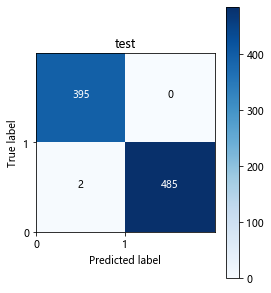

In [302]:
lr = LogisticRegression(C=best_c)
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_test_pred = lr.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

print("计算召回率：", cnf_matrix[1,1]/(cnf_matrix[1,0] + cnf_matrix[1,1]))
print("召回率", recall_score(y_test, y_test_pred))

plt.figure(figsize=(4,5))
plot_confusion_matrix(cnf_matrix, title="test")
plt.show()

In [287]:
l = y_test_pred != y_test
l[l==True]

317     True
2838    True
Name: expect, dtype: bool

In [301]:
predict = lr.predict(features)
recall_score(labels, predict)
cmp = pd.Series(labels != predict)
cmp[cmp==True]
features

,capacity,normPrice
0,80,0.233519
1,76,0.247246
2,75,1.567526
3,147,2.827893
4,50,-1.285230
...,...,...
2935,47,-0.569084
2936,95,-0.516451
2937,87,2.702531
2938,55,0.197117


计算召回率： 0.997946611909651
召回率 0.997946611909651


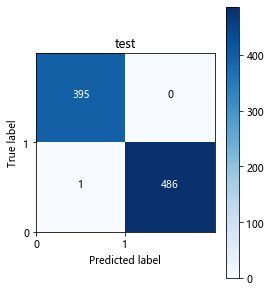

In [303]:
lr = LogisticRegression(C=best_c)
lr.fit(X_train, y_train.values.ravel())
y_test_pred = lr.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

print("计算召回率：", cnf_matrix[1,1]/(cnf_matrix[1,0] + cnf_matrix[1,1]))
print("召回率", recall_score(y_test, y_test_pred))

plt.figure(figsize=(4,5))
plot_confusion_matrix(cnf_matrix, title="test")
plt.show()

阈值为0.1, 测试召回率为：1.0
阈值为0.2, 测试召回率为：1.0
阈值为0.30000000000000004, 测试召回率为：1.0
阈值为0.4, 测试召回率为：1.0
阈值为0.5, 测试召回率为：1.0
阈值为0.6, 测试召回率为：0.9948717948717949
阈值为0.7000000000000001, 测试召回率为：0.982051282051282
阈值为0.8, 测试召回率为：0.9692307692307692
阈值为0.9, 测试召回率为：0.9641025641025641


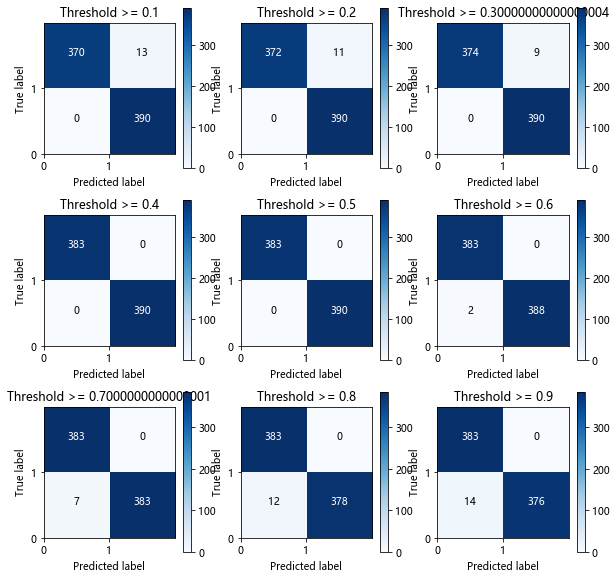

In [307]:
lr = LogisticRegression(C=best_c)
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_test_pred_proba = lr.predict_proba(X_test_undersample)

thresholds = np.arange(0.1,1,0.1)

plt.figure(figsize=(10,10))

for j, i in enumerate(thresholds, start=1):
    test_predict_recall = y_test_pred_proba[:,1] > i
    plt.subplot(3,3,j)

    cnf_matrix = confusion_matrix(y_test_undersample, test_predict_recall)
    np.set_printoptions(precision=2)

    print("阈值为{0}, 测试召回率为：{1}".format(i, recall_score(y_test_undersample, test_predict_recall)))

    plot_confusion_matrix(cnf_matrix, title="Threshold >= %s" % i)


In [308]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [314]:
feature_train, feature_test, label_train, label_test = train_test_split(features, labels, test_size=0.3, random_state=0)
os_feature, os_labels = SMOTE(random_state=0).fit_sample(feature_train, label_train)

In [311]:
best_c = Kfold_score(os_feature, os_labels)

-------
正则化惩罚力度 0.01
-------
召回率: 0.973384030418251 精准度:  0.9464668094218416
召回率: 0.9796747967479674 精准度:  0.9379014989293362
召回率: 0.9555555555555556 精准度:  0.9527896995708155
召回率: 0.9608540925266904 精准度:  0.9377682403433476
召回率: 0.9905660377358491 精准度:  0.869098712446352
平均召回率: 0.9720069025968627
平均精准度: 0.9288049921423387


-------
正则化惩罚力度 0.1
-------
召回率: 0.9771863117870723 精准度:  0.9807280513918629
召回率: 0.991869918699187 精准度:  0.987152034261242
召回率: 0.9925925925925926 精准度:  0.9914163090128756
召回率: 0.9679715302491103 精准度:  0.9763948497854077
召回率: 1.0 精准度:  0.9785407725321889
平均召回率: 0.9859240706655925
平均精准度: 0.9828464033967155


-------
正则化惩罚力度 1
-------
召回率: 0.9961977186311787 精准度:  0.9978586723768736
召回率: 1.0 精准度:  1.0
召回率: 0.9925925925925926 精准度:  0.9957081545064378
召回率: 0.9786476868327402 精准度:  0.9871244635193133
召回率: 1.0 精准度:  1.0
平均召回率: 0.9934875996113022
平均精准度: 0.9961382580805249


-------
正则化惩罚力度 10
-------
召回率: 1.0 精准度:  1.0
召回率: 1.0 精准度:  1.0
召回率: 0.9962962962962963 精准度:  0.99

召回率： 0.997946611909651


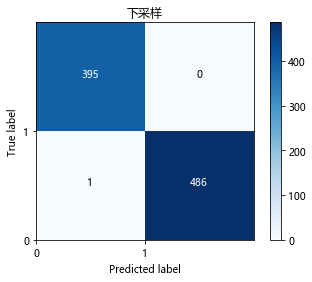

In [315]:
lr = LogisticRegression(C=best_c)
lr.fit(os_feature, os_labels.values.ravel())
y_labels_pred = lr.predict(feature_test)

cnf_matrix = confusion_matrix(label_test, y_labels_pred)
np.set_printoptions(precision=2)

print('召回率：', recall_score(label_test, y_labels_pred))

plt.figure()
plot_confusion_matrix(cnf_matrix, title="下采样")
plt.show()